In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!mkdir -p /content/drive/MyDrive/HCLTech_MVP

# Customer Future Spend Prediction (30 Days)

## Business Problem
For each **active customer**, estimate how much they will spend in the **next 30 days**.

This helps the business:
- Identify high-value customers
- Prioritize marketing spend
- Support short-term CLV estimation

## ML Framing
- **Type:** Supervised Learning (Regression)
- **Input (X):** Historical customer behavior up to a cutoff date
- **Target (y):** Total monetary spend in the next 30 days


In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv(
    "/content/drive/MyDrive/HCLTech_MVP/online_retail_II.csv",
    encoding="ISO-8859-1"
)

In [4]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


,Quantity,Price,Customer ID
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


In [5]:
# Strip whitespace from column names - cost us customer ID
df.columns = df.columns.str.strip()

# Rename columns safely
df = df.rename(columns={
    'Customer ID': 'CustomerID',
    'Invoice': 'InvoiceNo',
    'Price': 'UnitPrice'
})

We use the **last 30 days as the prediction window**.
All features are computed using data strictly before the cutoff date to avoid data leakage.

In [6]:
# Remove invalid rows
df = df.dropna(subset=['CustomerID'])
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

# Convert date
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

# Create total price
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

df.shape, df.head()

((805549, 9),
   InvoiceNo StockCode                          Description  Quantity  \
 0    489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
 1    489434    79323P                   PINK CHERRY LIGHTS        12   
 2    489434    79323W                  WHITE CHERRY LIGHTS        12   
 3    489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
 4    489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   
 
           InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  
 0 2009-12-01 07:45:00       6.95     13085.0  United Kingdom        83.4  
 1 2009-12-01 07:45:00       6.75     13085.0  United Kingdom        81.0  
 2 2009-12-01 07:45:00       6.75     13085.0  United Kingdom        81.0  
 3 2009-12-01 07:45:00       2.10     13085.0  United Kingdom       100.8  
 4 2009-12-01 07:45:00       1.25     13085.0  United Kingdom        30.0  )

In [7]:
# Choosing a time-based cutoff
cutoff_date = df['InvoiceDate'].quantile(0.8)
cutoff_date

Timestamp('2011-09-11 12:16:00')

In [8]:
# Customers who purchased in the last 90 days before cutoff
active_cutoff = cutoff_date - pd.Timedelta(days=90)

active_customers = df[
    df['InvoiceDate'] >= active_cutoff
]['CustomerID'].unique()

df_active = df[df['CustomerID'].isin(active_customers)]


### Feature Engineering (Customer-level RFM)

In [9]:
past_data = df_active[df_active['InvoiceDate'] < cutoff_date]

features = past_data.groupby('CustomerID').agg(
    recency=('InvoiceDate', lambda x: (cutoff_date - x.max()).days),
    frequency=('InvoiceNo', 'nunique'),
    total_spent=('TotalPrice', 'sum'),
    avg_spent=('TotalPrice', 'mean')
).reset_index()

features.head()

,CustomerID,recency,frequency,total_spent,avg_spent
0,12347.0,40,6,4114.18,21.098359
1,12348.0,159,4,1709.40,35.612500
2,12349.0,318,3,2671.14,26.187647
3,12352.0,172,7,1905.61,34.028750
4,12356.0,155,5,6315.33,44.789574


In [10]:
future_data = df_active[
    (df_active['InvoiceDate'] >= cutoff_date)
]

target = future_data.groupby('CustomerID')['TotalPrice'].sum().reset_index()
target.columns = ['CustomerID', 'future_spend_30d']

target.head()

,CustomerID,future_spend_30d
0,12347.0,1519.14
1,12348.0,310.00
2,12349.0,1757.55
3,12352.0,944.23
4,12356.0,58.35


### Combining target variable and features

In [11]:
data = features.merge(target, on='CustomerID', how='left')
data['future_spend_30d'] = data['future_spend_30d'].fillna(0)

data.head()

,CustomerID,recency,frequency,total_spent,avg_spent,future_spend_30d
0,12347.0,40,6,4114.18,21.098359,1519.14
1,12348.0,159,4,1709.40,35.612500,310.00
2,12349.0,318,3,2671.14,26.187647,1757.55
3,12352.0,172,7,1905.61,34.028750,944.23
4,12356.0,155,5,6315.33,44.789574,58.35


# EDA

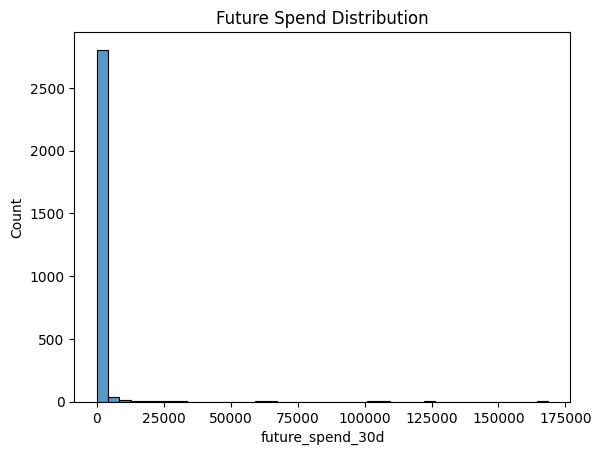

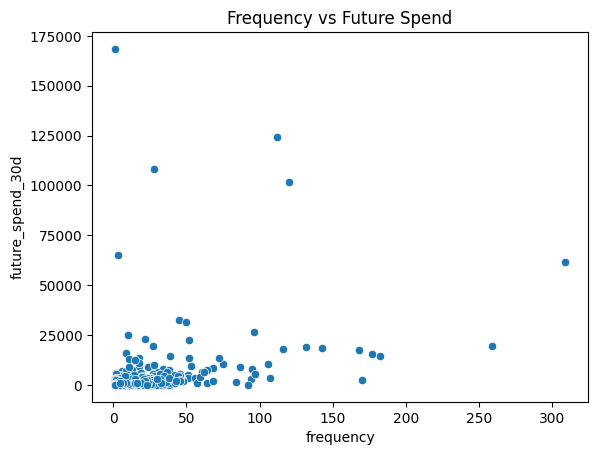

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of target
sns.histplot(data['future_spend_30d'], bins=40)
plt.title("Future Spend Distribution")
plt.show()

# Relationship with frequency
sns.scatterplot(
    x='frequency',
    y='future_spend_30d',
    data=data
)
plt.title("Frequency vs Future Spend")
plt.show()

In [13]:
X = data[['recency', 'frequency', 'total_spent', 'avg_spent']]
y = data['future_spend_30d']

In [14]:
baseline_prediction = y.mean()
baseline_prediction

np.float64(1056.2873990969088)

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print(rmse)

3809.0259764496773


In [19]:
# ---------- Baseline Model ----------

# Baseline prediction = mean of training target
baseline_prediction = y_train.mean()

# Predict same value for all test samples
baseline_predictions = np.full_like(y_test, baseline_prediction)

# Calculate RMSE for baseline
baseline_mse = mean_squared_error(y_test, baseline_predictions)
baseline_rmse = np.sqrt(baseline_mse)

print(baseline_rmse)

4767.410331794104


In [20]:
# Improvement percentage

improvement_pct = (baseline_rmse - rmse) / baseline_rmse * 100
print(improvement_pct)

20.102829180717098


In [21]:
import joblib
joblib.dump(model, "model.pkl")

['model.pkl']

## With XGBoost

In [27]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

Defining Parameter Grids - Keeping it small - Collab GPU uses too much computation power

In [28]:
param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200]
}

In [29]:
xgb = XGBRegressor(
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    device=None, early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [3, 5],
                         'n_estimators': [100, 200]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [32]:
best_xgb = grid_search.best_estimator_

best_preds = best_xgb.predict(X_test)

best_mse = mean_squared_error(y_test, best_preds)
best_rmse = np.sqrt(best_mse)

best_r2 = r2_score(y_test, best_preds)

print(best_rmse)
print(best_r2)

5253.194467158798
-0.21436675058392307


# With Lasso Regression

In [33]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

In [34]:
lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(alpha=0.1, random_state=42))
])

In [35]:
lasso_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.1, random_state=42))])

In [38]:
lasso_preds = lasso_pipeline.predict(X_test)

lasso_mse = mean_squared_error(y_test, lasso_preds)
lasso_rmse = np.sqrt(lasso_mse)
lasso_r2 = r2_score(y_test, lasso_preds)

print(lasso_rmse)
print(lasso_r2)

3477.8763969242013
0.467730969748703


In [39]:
joblib.dump(lasso_pipeline, "lasso_model.pkl")

['lasso_model.pkl']